# Data Modeling

Now that we've cleaned and explored our data, we can start working on modeling it. 

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import sklearn as sk
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, cross_val_score, TimeSeriesSplit
from sklearn.linear_model import Lasso, ElasticNet, LinearRegression
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
import tensorflow as tf

First, let's import all of our cleaned .csv files

In [4]:
df = pd.read_csv('../data/clean/full/dengue_features_train.csv')
df_labels = pd.read_csv('../data/clean/full/dengue_features_train.csv')
sj_features = pd.read_csv('../data/clean/sj/sj_train_features.csv')
sj_labels = pd.read_csv('../data/clean/sj/sj_train_labels.csv')

iq_features = pd.read_csv('../data/clean/iq/iq_train_features.csv')
iq_labels = pd.read_csv('../data/clean/iq/iq_train_labels.csv')

Now, we can start playing around with algorithms and their hyperparameters

In [5]:
lasso = Lasso()
enet = ElasticNet()
reg = LinearRegression()

lasso_params = {
    'alpha':[1, 5, 10, 100],
}

enet_params = {
    'alpha':[.1, 1, 5, 10, 100],
    'l1_ratio':[.1, .5, .9],
}

for estimator, params in zip([lasso, enet, reg], [lasso_params, enet_params, {}]):
    grid_search = GridSearchCV(
        estimator=estimator,
        param_grid=params,
        scoring='neg_mean_absolute_error',
        cv=5,
        n_jobs=-1,
    )
    grid_search.fit(sj_features.drop(['city', 'week_start_date'], axis=1), sj_labels['total_cases'])
    print(sj_features['city'].unique()[0], grid_search.best_score_, grid_search.best_estimator_)
    

sj -27.60013422946121 Lasso(alpha=100, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
sj -27.288571587403965 ElasticNet(alpha=100, copy_X=True, fit_intercept=True, l1_ratio=0.1,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
sj -30.038683611654715 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


As we can see, the scores for ElasticNet, L2 Least Squares, and Linear Regression come out to 28, 27, and 30 respectively. We can also see that the estimators with complexity penalties find that a higher penalty leads to a better score. This, however, is slightly false. By visualizing the results we can see they are actually just regressing towards the mean of the `total_cases` column.

# More than a Baseline

Now that we have simple, interpretable models as our baseline, we can start to increase the complexity. 

In [27]:
xgb = XGBRegressor(
    objective ='reg:squarederror'
)

xgb_params = {
    'eta': [0,.5,1],
    'gamma': [0, 10],
    'lambda': [0, 10],
    'max_depth': [1, 10],
    'n_estimators':[1, 10, 20], # Number of trees 
    'min_child_weight':[0,1,100]
}

grid_search = GridSearchCV(
    estimator = xgb,
    param_grid = xgb_params,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=10,
)

grid_search.fit(sj_features.drop(['city', 'week_start_date'], axis=1), sj_labels['total_cases'])
grid_search.best_params_, grid_search.best_score_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0211s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0544s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.1s


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1508s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 288 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 824 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 960 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:   11.7s finished


({'eta': 0,
  'gamma': 0,
  'lambda': 0,
  'max_depth': 1,
  'min_child_weight': 100,
  'n_estimators': 10},
 -22.758669192355057)

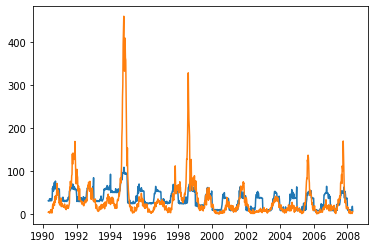

In [31]:
plt.plot(pd.to_datetime(sj_features['week_start_date']), grid_search.predict(sj_features.drop(['city', 'week_start_date'], axis=1)))
plt.plot(pd.to_datetime(sj_features['week_start_date']), sj_labels['total_cases'])

As we can see, the grid search finds that the best parameters are those that make simple trees with only one spit. By inspection, it's clear that the model starting to capture some trends in seasonality, but does so in a rather simple way. To avoid this, let's force the number of estimators to be constant, and then fit the other parameters to that.

In [35]:
xgb_params['n_estimators'] = [100]
xgb_params['min_child_weight'] = [0]
grid_search.fit(sj_features.drop(['city', 'week_start_date'], axis=1), sj_labels['total_cases'])
grid_search.best_params_, grid_search.best_score_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1389s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   11.7s finished
/Users/jmlehrer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/Users/jmlehrer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



({'eta': 0,
  'gamma': 0,
  'lambda': 0,
  'max_depth': 1,
  'min_child_weight': 0,
  'n_estimators': 100},
 -31.88598407023134)

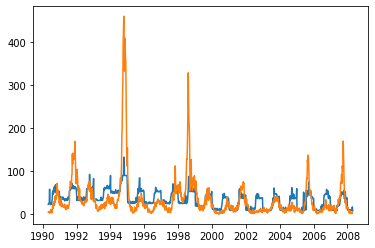

In [37]:
plt.plot(pd.to_datetime(sj_features['week_start_date']), grid_search.predict(sj_features.drop(['city', 'week_start_date'], axis=1)))
plt.plot(pd.to_datetime(sj_features['week_start_date']), sj_labels['total_cases'])

Visually, the model seems to be similar. However, it's hard to tell if the model has actually improved without making a submission, as our overall CV score has increased to ~31. 

# More testing
Let's try fitting this model on the entire dataset, rather than just 

Index(['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'reanalysis_air_temp_k', 'reanalysis_avg_temp_k',
       'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_tdtr_k', 'station_avg_temp_c', 'station_diur_temp_rng_c',
       'station_max_temp_c', 'station_min_temp_c', 'station_precip_mm'],
      dtype='object')